# PCA & K-Means Cluster Analysis of Personal IMDB Ratings
### Objectives:
1. Attempting to Find patterns in IMDB Ratings over a period of 5 Years.<b> Find insights about preferences etc., Important Features </b>Using (I) EDA (II) K-Means Clustering.
2. Find <b>Interesting Clusters of Movies Using K-Means Clustering</b>, gathering Insight on preferences.
3. Use <b>Principal Component Analysis </b>to improve Clustering output.

### TO DO 
Conclusion

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path
import warnings

pd.set_option('display.max_rows', 1000)
warnings.filterwarnings('ignore')

In [47]:
path = str(Path.cwd()) + '/imdb_ratings_april_2020.csv'

data = pd.read_csv(path, engine='python', index_col=0)

In [48]:
# Filter Dataframe

film_filt = (data['Title Type'] == 'movie')
data_film = data.loc[(film_filt)]
# Keeping Backup Dataframe
data_film_orig = data_film

## 1. Exploratory Analysis & Visualizations

### Univariate 

#### BoxPlots for Quantitative Vars.
Insights:
1. Most of the Ratings lie between the rating 7 and 8, this is slightly lower compared to the IMDb users, But this could be misleading as Discrete vs Continuous Comaprison.
2. The author generally likes watching Longer Movies.
3. Although most movies watched are newer, their is a long tail towards older movies, author doesn't mind the occassional older movies.
4. Majority of the movies watched are on the lower end of Popularity. 

In [167]:
def plot_box_num_uni(df):
    """ Plots Boxplots for all Numerical Columns in Dataframe.
    """
    fig = plt.figure()
    fig.set_figheight(30)
    fig.set_figwidth(20)
    for i, item in enumerate(df.select_dtypes([np.number]).columns.to_list()):
        ax = fig.add_subplot(len(df.select_dtypes([np.number]).columns.to_list()), 3, i+1)
        sns.boxplot(x = str(item), data = df)
        ax.set_title(item)

    fig.show()

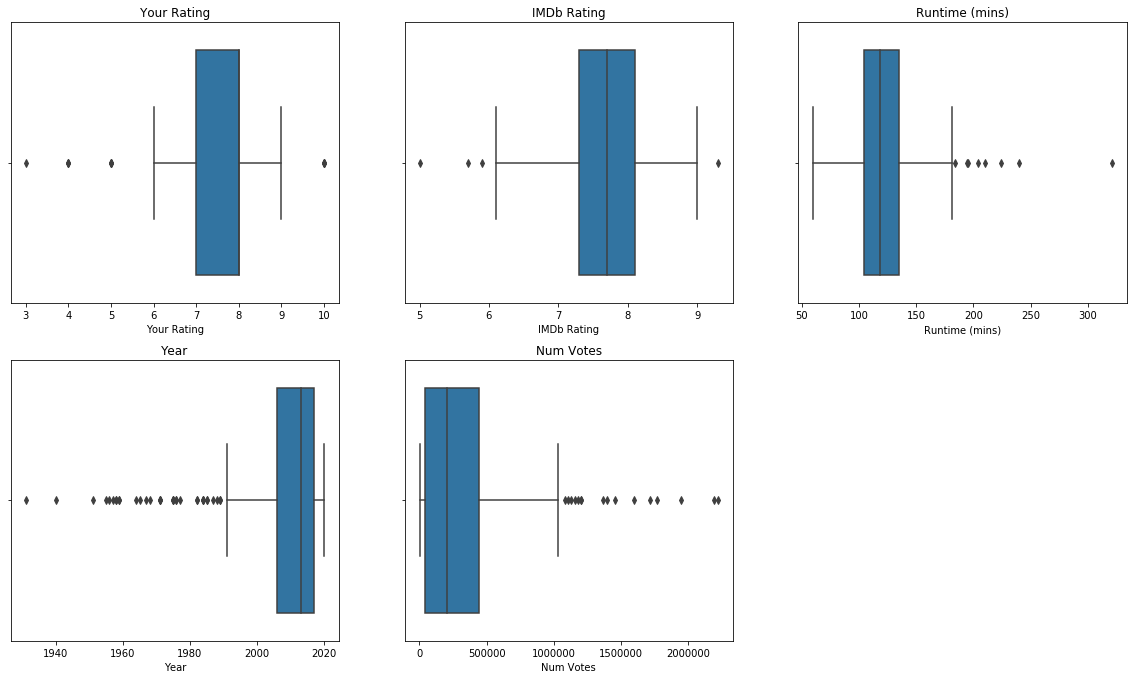

In [168]:
plot_box_num_uni(data_film)

#### Division of Ratings accross Genres

In [7]:
data_film[['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6','Genre7']] = data_film.Genres.str.split(',', expand=True)
data_film.drop(['Genre2','Genre3', 'Genre4','Genre5','Genre6','Genre7'], axis= 1, inplace = True)
# Loss of info by dropping secondary, tertiary genres but will result in duplication, is complex.

In [8]:
# Loss of info, Lee ukreich, ethan and joel coen etc are big loosers. Complex fix later.
data_film[['Director1','Director2','Director3', 'Director4']] = data_film.Directors.str.split(',', expand=True)
data_film.drop(['Director2','Director3', 'Director4'], axis = 1, inplace = True)

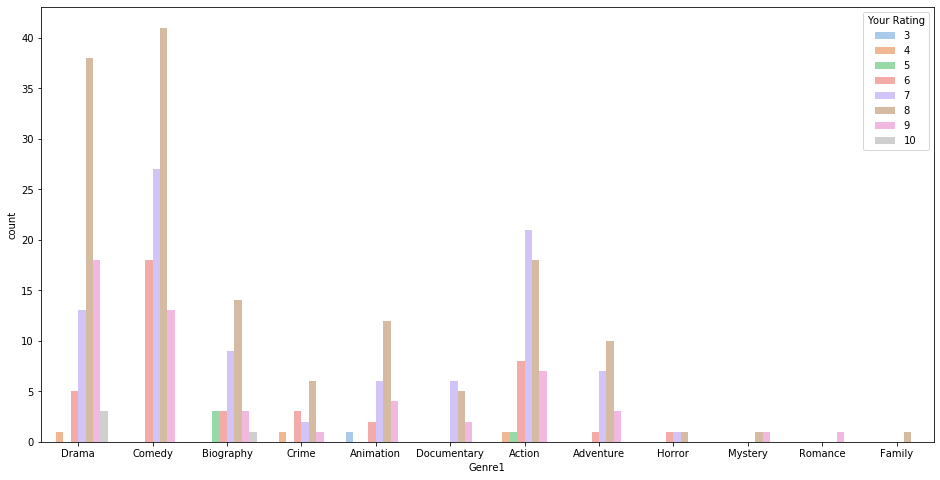

In [9]:
plt.figure(figsize=(16,8))
ax = sns.countplot(x = 'Genre1', data = data_film, hue="Your Rating", palette="pastel")
ax.legend(loc='upper right', title = 'Your Rating')
plt.show()

#### Most Watched Directors

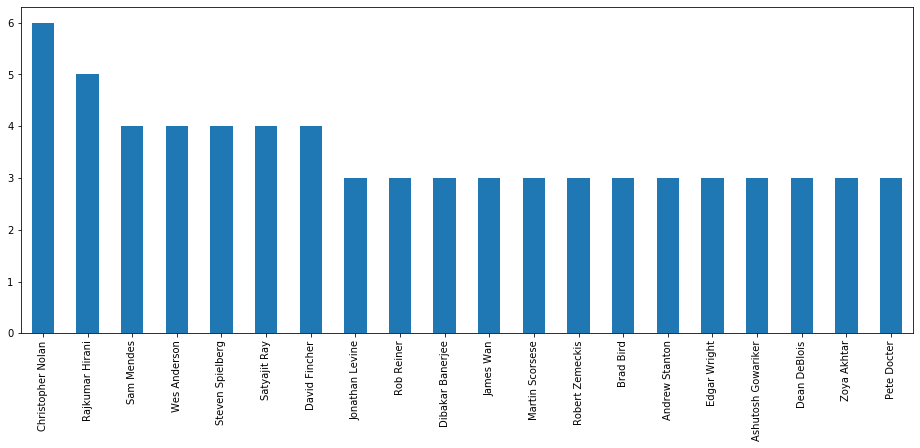

In [10]:
plt.figure(figsize = (16,6))
data_film.Director1.value_counts()[:20].plot(kind = 'bar')
plt.show()

## Bivariate Analysis With Respect to 'Your Rating'
1. I generally follow the same trends as the IMDb ratings. The movies I've rated the highest tend to be highly rated movies in general. There is a large percentage of movies I've rated lower that the IMDb public likes.
2. The lowest rated movies tend to have longer run times compared to the average movies. The highest rated movies tend to be longer too.
3. Most higher rated movies are more spread out when it comes to year of release. The violin plot shows this better.
4. There is high spread in the popularity of the movies rated higher. Will check relationship using Linear Regression later.

In [11]:
def plot_box_num_biv(df, categ):
    """ Plots Boxplots for all Numerical Columns in Dataframe with respect to a categorical column.
    """
    fig = plt.figure()
    fig.set_figheight(30)
    fig.set_figwidth(20)
    for i, item in enumerate(df.select_dtypes([np.number]).columns.to_list()):
        ax = fig.add_subplot(len(df.select_dtypes([np.number]).columns.to_list()), 2, i+1)
        sns.boxplot(x = categ, y = str(item), data = df)
        ax.set_title(item)

    fig.show()

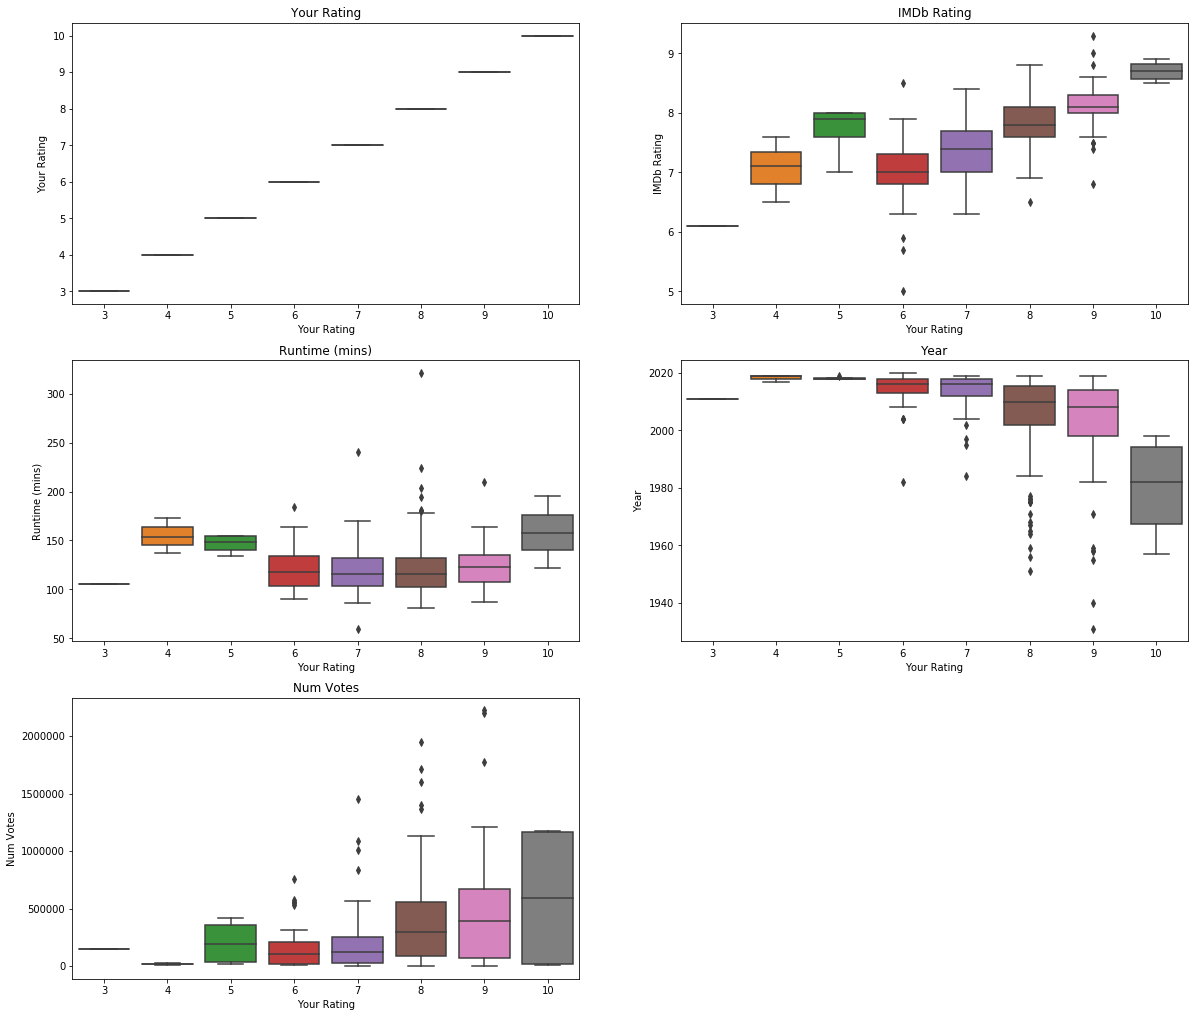

In [12]:
plot_box_num_biv(data_film, 'Your Rating')

## Checking Relationships Between Data

### Checking Pearsons Correlation 

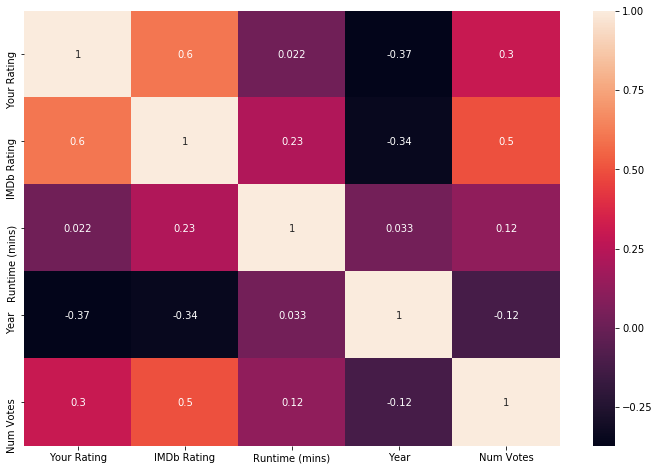

In [13]:
plt.figure(figsize=(12,8))
sns.heatmap(data = data_film.corr(), annot=True)
plt.show()

## Linear Regression Plots to check If there is a Linear Relationships between Your Rating and Other Quantitaive Vars., Comparison with IMDb Users.
0. A strong relationship is not expected between Your Ratings (sample) and IMDb Ratings (population), this is backed up by the first plot. It was observed that the std deviation for Your rating is greater, which is to be expected from a sample of size 1. But this is not of interest as we want to know which features contribute most to the Ratings and whether there is significant difference between the author and the IMDB Population.
1. There is a Strong Positive Linear Relationship between IMDb user Ratings and My Ratings, not significantly different ratings, makes sense as movies rated higher by the population would be good movies in geneal. There are quite a few outliers visible. More interested in these values as they could show possible pecularities in taste and important features.
2. No Significant Relationship linear relationship between runtime and Your rating. There are high leverage points. Weaker relationship compared to Imdb Users.
3. Appears to be weak negative relationship between Year of release and Your Rating, stronger than other IMDb users , author favors older movies but could be possible that only good older movies watched. (Check Leverage Statistics to see if this is a problem.)
4. Appears to be a weak positive relationship between popularity (Num of votes) and Your rating. Some high leverage points. Comparing with Rating by IMDb users, this relationship appears to be extremely similar but larger confidence interval. So yeah, popular movies tend to be rated higher, again could just be a correlation.

In [14]:
def plot_lin_num_biv(df):
    """ Plots Boxplots for all Numerical Columns in Dataframe with respect to a categorical column.
    """
    fig = plt.figure()
    fig.set_figheight(30)
    fig.set_figwidth(20)
    for i, item in enumerate(df.select_dtypes([np.number]).columns.to_list()):
        ax = fig.add_subplot((len(df.select_dtypes([np.number]).columns.to_list())), 2, i+1)
        sns.regplot(y = 'Your Rating', x = str(item), data = data_film, label = 'Your Ratings')
        sns.regplot(y = 'IMDb Rating', x = str(item), data = data_film, label = 'IMDb Ratings')
        ax.legend()
        ax.set_ylabel('Rating')
        ax.set_title('IMDb Rating, Your Rating - ' + item)
    fig.show()

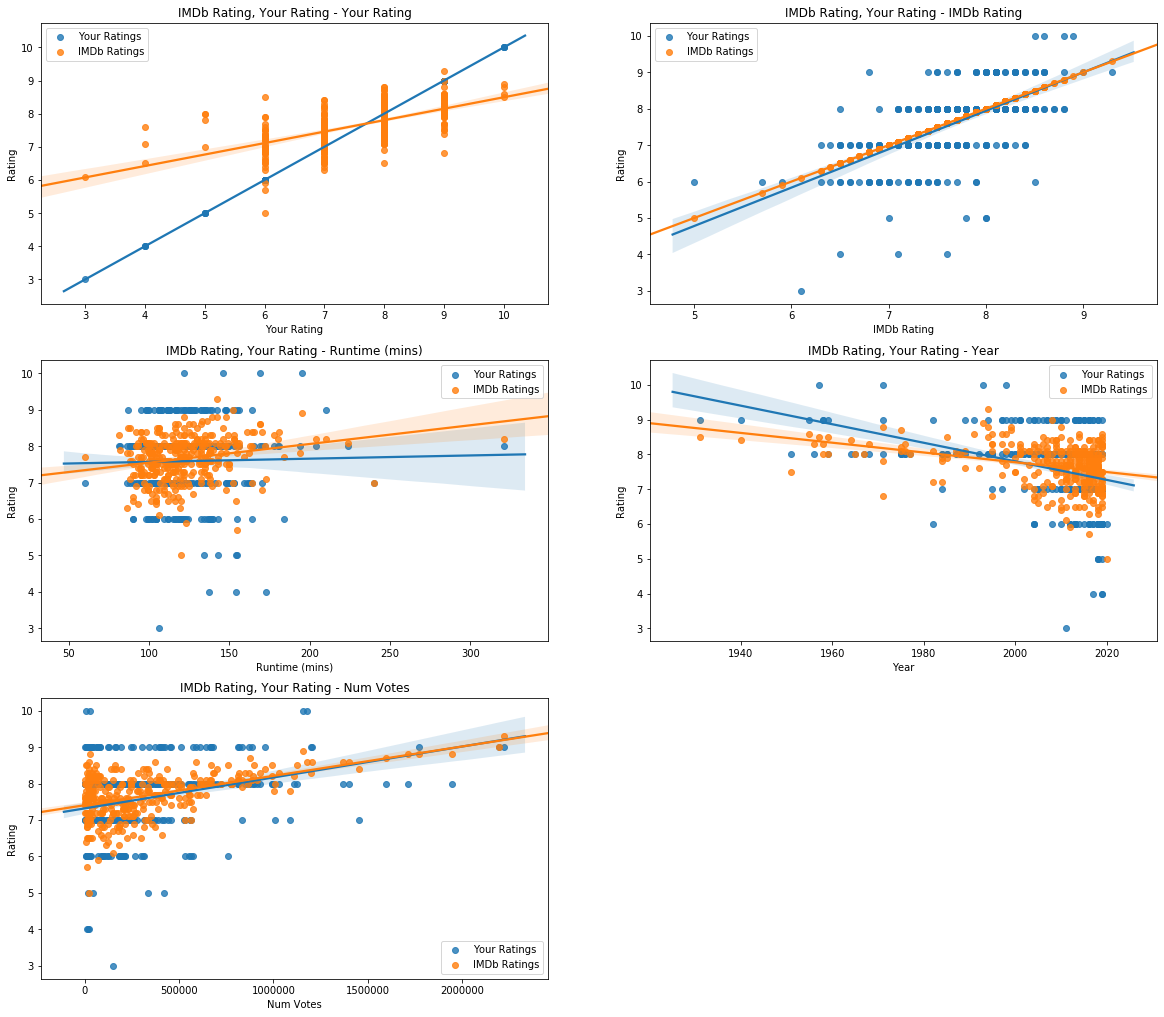

In [15]:
plot_lin_num_biv(data_film)

# 2. PCA and K-Means Clustering

### Feature Engineering, Dropping Useless columns, One-hot Encodding Categorical Column like Genre, Director etc.

In [16]:
data_film.drop(['Genres', 'Directors'], axis = 1, inplace = True)

#### Lets see if we can Eye-ball clusters.

Text(0, 0.5, 'Rating')

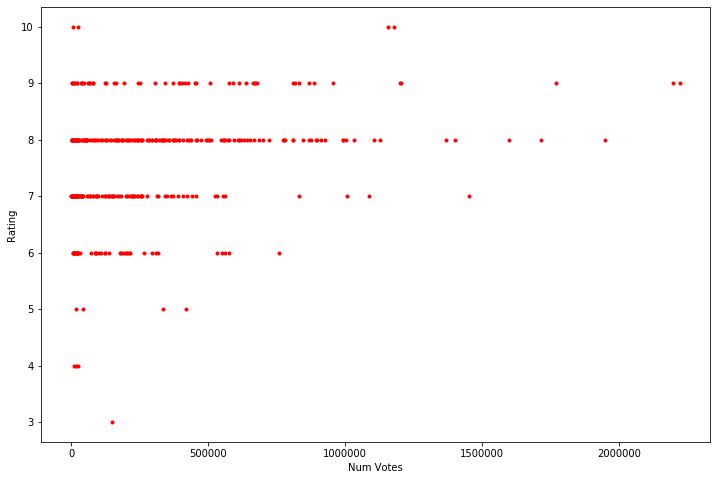

In [17]:
plt.figure(figsize=(12,8))
plt.plot( data_film['Num Votes'], data_film['Your Rating'].to_list(), 'r.')
plt.xlabel('Num Votes')
plt.ylabel('Rating')

#### Feature Engineering - One - Hot encode Genre, Directors and Dropping a few Columns, Convert Rated to Numerical

In [18]:
data_film = pd.get_dummies(data_film, prefix='Genre', columns=['Genre1'])
data_film = pd.get_dummies(data_film, prefix='Director', columns=['Director1'])
data_film[['Rated_Year', 'Rated_month', 'Rated_Day']] = data_film['Date Rated'].str.split('-', expand = True)
data_film.drop(['Rated_month', 'Rated_Day'], axis = 1, inplace = True)
data_film.drop('Date Rated', axis = 1, inplace = True)
data_film[['Release_Year', 'Release_month', 'Release_Day']] = data_film['Release Date'].str.split('-', expand = True)
data_film.drop(['Release_month', 'Release_Day'], axis = 1, inplace = True)
data_film.drop('Release Date', axis = 1, inplace = True)
data_film.drop(['Title Type', 'URL'], axis = 1, inplace = True)

#### Making Copy as we'll drop Title and convert to numeric

In [19]:
data_film_num = data_film
data_film_num.drop(['Title'], axis = 1, inplace=True)
data_film_num.drop(['Release_Year'], axis = 1, inplace=True)
data_film_num['Rated_Year'] = data_film_num['Rated_Year'].astype(int)

#### Visualizing New Info

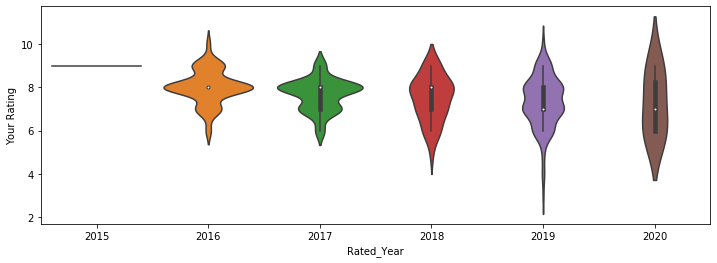

In [20]:
plt.figure(figsize=(12,4))
sns.violinplot(x = 'Rated_Year', y = 'Your Rating', data =data_film_num )

# Curse of Dimensionality - 273 Features for 345 samples. 

# Principal Components Analysis to Reduce Dimensionality of Data

#### Standardize Data

In [21]:
from sklearn.preprocessing import StandardScaler
data_film_scaled = StandardScaler().fit_transform(data_film_num.values)

#### Restoring Indexes And Column Names

In [22]:
data_film_scaled_df = pd.DataFrame(data = data_film_scaled, index = data_film_num.index, columns = data_film_num.columns)

#### Lets Target that 50% Percent of the Variance is explained by the principal components - Explained by 120 Features.

In [23]:
from sklearn.decomposition import PCA

target_variance = 0.50

for i in range(len(data_film_scaled_df.columns)):
    pca_film = PCA(n_components=i)
    pca_components_film = pca_film.fit_transform(data_film_scaled_df)
    #print(f'Total Explained Variance is {np.sum(pca_film.explained_variance_ratio_)}')
    if np.sum(pca_film.explained_variance_ratio_) > target_variance:
        #print(f'No of Components that explain 50% of Variance: {i}')
        break

print(f'No of Components that explain 50% of Variance: {i}')

No of Components that explain 50% of Variance: 120


### Visualizing important Features for First Principal Component
No single features dominates, which is good.

In [25]:
first_comp = pca_film.components_[0]
# Creating Dataframe for correspoding Columns in original Dataframe
first_comps = pd.DataFrame(zip(first_comp, data_film_scaled_df.columns), columns = ['Weights', 'Features'])
first_comps['abs_weights']=first_comps['Weights'].apply(lambda x: np.abs(x))
first_comps.sort_values('abs_weights', ascending=False)[:10]

,Weights,Features,abs_weights
1,0.458327,IMDb Rating,0.458327
0,0.408970,Your Rating,0.408970
4,0.346599,Num Votes,0.346599
3,-0.288688,Year,0.288688
9,-0.213825,Genre_Comedy,0.213825
12,0.180817,Genre_Drama,0.180817
2,0.150680,Runtime (mins),0.150680
272,-0.142391,Rated_Year,0.142391
69,0.127985,Director_Christopher Nolan,0.127985
97,0.100570,Director_Frank Darabont,0.100570


In [26]:
list_pca_film = list(pca_components_film)

## Visualizing the High Dimensional data and Principal Components using T-SNE
Some clusters are visible by eye in the tsne output of the pricipal components, lets see if the Clustering algorithm picks this up.

In [29]:
from sklearn.manifold import TSNE

In [32]:
embed_scale = TSNE(n_components=2).fit_transform(data_film_scaled_df)
embed_pc = TSNE(n_components=2).fit_transform(pca_components_film)

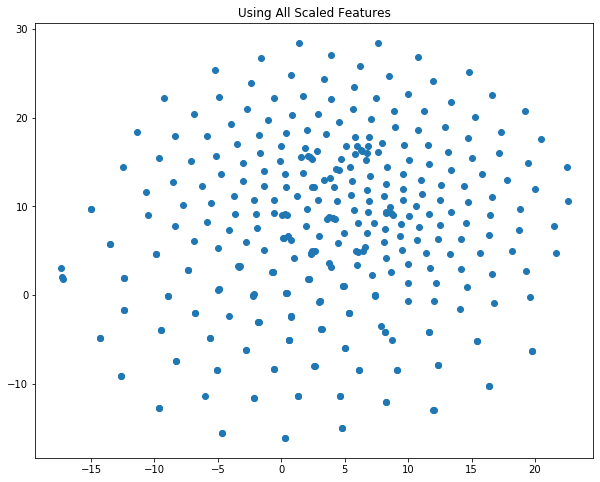

In [39]:
plt.figure(figsize=(10,8))
plt.title('Using All Scaled Features')
plt.scatter(embed_scale[:,:1],embed_scale[:,1:])

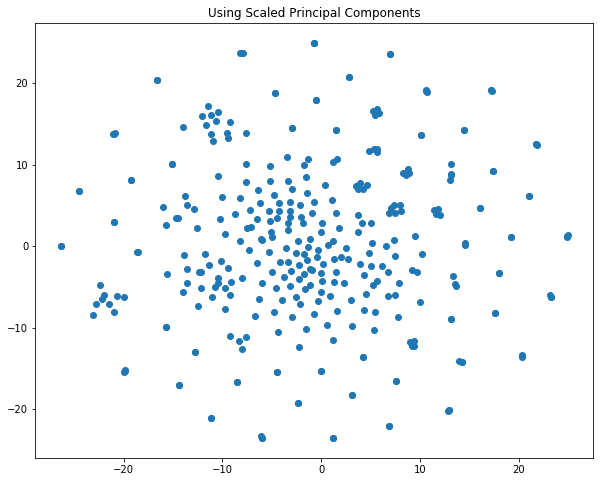

In [152]:
plt.figure(figsize=(10,8))
plt.title('Using Scaled Principal Components')
plt.scatter(embed_pc[:,:1],embed_pc[:,1:])

# Fitting Kmeans - Clustering Using Principal Components

### Finding Optimal Number of Clusters - Using Elbow Method and SSE Score
1. An Elbow somewhat appears at 85 clusters. 

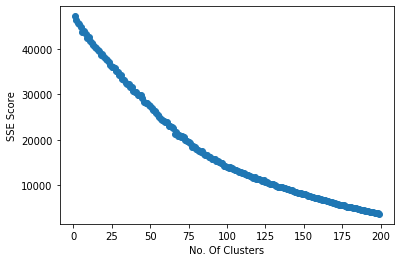

In [27]:
# calculate distortion for a range of number of cluster
from sklearn.cluster import KMeans

distortions = []
for i in range(1,200):
    cluster_film = KMeans(n_clusters = i, n_init=10, max_iter= 100).fit(list_pca_film)
    distortions.append(cluster_film.inertia_)
    
plt.xlabel('No. Of Clusters')
plt.ylabel('SSE Score')
plt.plot(range(1, 200), distortions, marker='o')
plt.savefig('Clusters_SSE_plot.jpg')

In [28]:
cluster_film = KMeans(n_clusters = 85, n_init=10, max_iter= 100).fit(list_pca_film)
pred_film = cluster_film.labels_

### Lets Place the cluster labels back into dataframe and check which Movies got Clustered Together.

In [183]:
data_film_orig = data.loc[(film_filt)]
data_film_orig['Cluster'] = pred_film
# saving clusters.
data_film_orig.to_csv('Clusters_from_k_means_pca.csv')

# Visualizing and Analyzing the Clusters

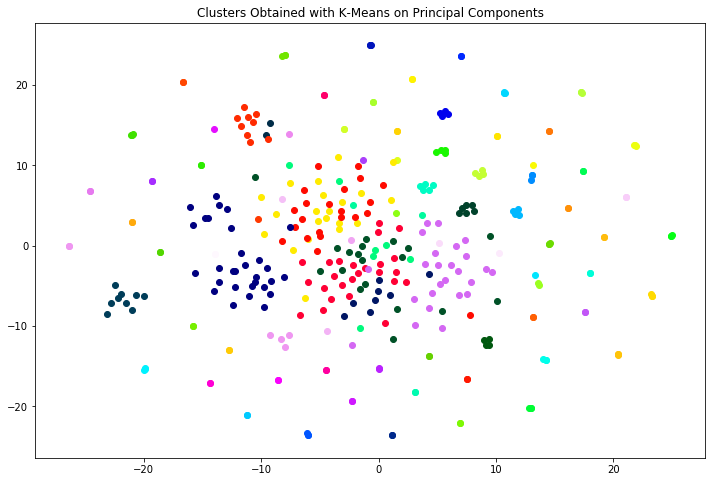

In [155]:
grouped_df = data_film_orig.groupby(['Cluster'])
embed_df = pd.DataFrame({'ax1': embed_scale[:,:1].ravel(), 'ax2': embed_scale[:,1:].ravel(), 'clusters': pred_film})
embed_pc_df = pd.DataFrame({'ax1': embed_pc[:,:1].ravel(), 'ax2': embed_pc[:,1:].ravel(), 'clusters': pred_film})
grouped_df_pc = embed_pc_df.groupby('clusters')
plt.figure(figsize = (12,8))
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.gist_ncar(np.linspace(0, 1, 84))))
for i in range(85):
    plt.scatter(grouped_df_pc.get_group(i).ax1.tolist(), grouped_df_pc.get_group(i).ax2.tolist(), label = i)
plt.title('Clusters Obtained with K-Means on Principal Components')
plt.show()

### Investigating Clusters

### Cluster Statistics - 
1. Checking Difference in Mean of Your Rating and IMDb Rating for clusters.
2. Mean difference in Runtime(Length).
3. Median Num Votes(Popularity) as data is Highly Skewed.
4. Median Year of Release.

In [252]:
data_film_cluster_stats = data_film_orig.groupby(['Cluster'])['Your Rating'].count()
data_film_cluster_stats = data_film_cluster_stats.to_frame('Count')
data_film_cluster_stats['your_imdb_Rating_Mean_Difference'] = data_film_orig.groupby(['Cluster'])['Your Rating'].mean() - data_film_orig.groupby(['Cluster'])['IMDb Rating'].mean()
data_film_cluster_stats['RunTime_Mean_Difference'] = data_film_orig.groupby(['Cluster'])['Runtime (mins)'].mean() - data_film_orig['Runtime (mins)'].mean()
data_film_cluster_stats['votes_Median_Difference'] = data_film_orig.groupby(['Cluster'])['Num Votes'].median() - data_film_orig['Num Votes'].median()
data_film_cluster_stats['Year_Median_diff'] = data_film_orig.groupby(['Cluster'])['Year'].median() - data_film_orig['Year'].median()
data_film_cluster_stats.sort_values('Count', ascending=False, inplace=True)

#### 1 Sample T-Test to compare population your rating and cluster your rating.

In [338]:
# Lets perform 1 sample t test between population your rating (data_film) and sample clust_0
from scipy.stats import ttest_1samp

def ttest_1samp_cluster_pop(cluster_number):
    pop_film = data_film['Your Rating'].tolist()
    print(f'Population Mean {np.mean(pop_film)}, degrees of freedom {len(pop_film)}')

    clust_3_sample = grouped_df.get_group(cluster_number)['Your Rating'].tolist()
    print(f'Sample mean {np.mean(clust_3_sample)}, degrees of freedom {len(clust_3_sample)}')

    tstat, pvalue = ttest_1samp(clust_3_sample, np.mean(pop_film))
    print('\nT-Stat for hypothesis test {} and P-value {}'.format(tstat, pvalue))
    print('T-critical for n = {}, alpha = 0.05 is'.format(len(clust_3_sample)-1))
    if pvalue<0.05:
        print('Statistically significant result')
    else:
        print('Statistically insignificant result')

In [225]:
def get_genre_cluster(genre = 'Animation'):
    return data_film_orig.loc[data_film.Genres.str.split(',', expand=True)[0] == genre].sort_values('Cluster')

### 1. Clusters of Interest on the basis of Mean Difference in Rating between Your Rating and IMDb Ratings

In [306]:
# Only Keeping clusters with atleast 3 movies
cluster_stat_large = data_film_cluster_stats.loc[(data_film_cluster_stats['Count'] >=3)]
cluster_stat_large.sort_values('your_imdb_Rating_Mean_Difference').head(5)

,Count,your_imdb_Rating_Mean_Difference,RunTime_Mean_Difference,votes_Median_Difference,Year_Median_diff
Cluster,,,,,
12,3,-1.266667,7.295652,131146.0,3.0
6,9,-0.866667,0.073430,232993.0,3.0
84,9,-0.777778,-18.926570,107782.0,0.0
20,5,-0.700000,33.228986,-133071.0,-4.0
1,8,-0.575000,-2.746014,-142143.0,-1.5


In [182]:
cluster_stat_large.sort_values('your_imdb_Rating_Mean_Difference').tail(5)

,Count,your_imdb_Rating_Mean_Difference,RunTime_Mean_Difference,votes_Median_Difference,Year_Median_diff
Cluster,,,,,
46,21,0.504762,-0.894824,-47522.0,-1.0
4,4,0.525000,-26.371014,-34436.5,-2.5
27,4,0.525000,30.628986,764168.0,-13.0
17,3,0.533333,-21.037681,90756.0,1.0
51,3,0.666667,-14.371014,203581.0,-3.0


### 2. Clusters of Interest on the basis of Mean difference in Runtime(Length).

In [172]:
cluster_stat_large = data_film_cluster_stats.loc[(data_film_cluster_stats['Count'] >=3)]
cluster_stat_large.sort_values('RunTime_Mean_Difference').head(5)

,Count,your_imdb_Rating_Mean_Difference,RunTime_Mean_Difference,votes_Median_Difference,Year_Median_diff
Cluster,,,,,
18,3,0.133333,-30.704348,-16223.0,-26.0
59,9,-0.122222,-29.148792,-183258.0,3.0
8,3,-0.133333,-28.037681,578074.0,-4.0
4,4,0.525000,-26.371014,-34436.5,-2.5
43,3,0.066667,-24.037681,709233.0,-5.0


In [184]:
cluster_stat_large.sort_values('RunTime_Mean_Difference').tail(5)

,Count,your_imdb_Rating_Mean_Difference,RunTime_Mean_Difference,votes_Median_Difference,Year_Median_diff
Cluster,,,,,
3,6,-0.533333,22.462319,1224601.5,-2.0
27,4,0.525000,30.628986,764168.0,-13.0
20,5,-0.700000,33.228986,-133071.0,-4.0
32,3,-0.033333,36.962319,-176247.0,2.0
33,3,0.333333,73.962319,-123867.0,-9.0


### 3. Clusters of Interest on the basis of Median Num Votes(Popularity)

In [174]:
cluster_stat_large = data_film_cluster_stats.loc[(data_film_cluster_stats['Count'] >=3)]
cluster_stat_large.sort_values('votes_Median_Difference').head(5)

,Count,your_imdb_Rating_Mean_Difference,RunTime_Mean_Difference,votes_Median_Difference,Year_Median_diff
Cluster,,,,,
9,4,0.150000,-12.371014,-191972.5,-56.0
39,3,0.466667,10.628986,-187085.0,-5.0
59,9,-0.122222,-29.148792,-183258.0,3.0
32,3,-0.033333,36.962319,-176247.0,2.0
26,3,-0.300000,-1.037681,-175945.0,2.0


In [185]:
cluster_stat_large.sort_values('votes_Median_Difference').tail(5)

,Count,your_imdb_Rating_Mean_Difference,RunTime_Mean_Difference,votes_Median_Difference,Year_Median_diff
Cluster,,,,,
43,3,0.066667,-24.037681,709233.0,-5.0
27,4,0.525000,30.628986,764168.0,-13.0
15,3,-0.566667,13.628986,790919.0,-19.0
40,4,-0.050000,11.378986,887431.0,-8.5
3,6,-0.533333,22.462319,1224601.5,-2.0


### 4. Clusters of Interest on the basis of Median Year of Release.

In [176]:
cluster_stat_large = data_film_cluster_stats.loc[(data_film_cluster_stats['Count'] >=3)]
cluster_stat_large.sort_values('Year_Median_diff').head(5)

,Count,your_imdb_Rating_Mean_Difference,RunTime_Mean_Difference,votes_Median_Difference,Year_Median_diff
Cluster,,,,,
9,4,0.150000,-12.371014,-191972.5,-56.0
18,3,0.133333,-30.704348,-16223.0,-26.0
15,3,-0.566667,13.628986,790919.0,-19.0
27,4,0.525000,30.628986,764168.0,-13.0
33,3,0.333333,73.962319,-123867.0,-9.0


In [186]:
grouped_df = data_film_orig.groupby(['Cluster'])

## Interpreting Largest Clusters

#### Cluster 73 - Cluster of Newer Action-Adventure, Drama, Sci-Fi , Superhero movies.
1. 25 Films.
2. Rated Less favourably.
3. Newer Films, reasonably popular.
4. Statistically Significant preference compared to all Your Ratings.

In [340]:
#grouped_df.get_group(73).head()
ttest_1samp_cluster_pop(73)

Population Mean 7.58840579710145, degrees of freedom 345
Sample mean 7.12, degrees of freedom 25

T-Stat for hypothesis test -3.227188621192152 and P-value 0.0035957593287332637
T-critical for n = 24, alpha = 0.05 is
Statistically significant result


#### Cluster 62 - Cluster of Newer Romantic Comedies, Dramas.
1. 25 Films.
2. Rated about the same as IMDb Users.
3. Newer Films, much less popular than median.
4. Statistically Insignificant Result.

In [345]:
#grouped_df.get_group(62).head(100)
#ttest_1samp_cluster_pop(62)

#### Cluster 61 - Cluster of Newer Dramas.
1. 22 Films.
2. Rated Less favourably.
3. Newer Films, not popular.
4. Statistically Insignificant Result.

In [346]:
#grouped_df.get_group(61).head(100)
#ttest_1samp_cluster_pop(61)

#### Cluster 61 - Cluster of Acclaimed Biographies.
1. 21 Films.
2. Rated about the same as IMDb users.
3. Popular Films
4. Statistically Insignificant Result.

In [347]:
#grouped_df.get_group(0).head(100)
#ttest_1samp_cluster_pop(0)

#### Cluster 46 - Highly Rated Drama, Dramas with comedy, Romantic elements.
1. 21 Films.
2. Rated Much more favourably, author clearly prefers these genres.
3. Less popular than the median.
4. Statistically Significant Result.

In [343]:
#grouped_df.get_group(46).head()
ttest_1samp_cluster_pop(46)

Population Mean 7.58840579710145, degrees of freedom 345
Sample mean 8.333333333333334, degrees of freedom 21

T-Stat for hypothesis test 4.289508201285393 and P-value 0.0003575218358831785
T-critical for n = 20, alpha = 0.05 is
Statistically significant result


##  Interpreting Clusters with Skewed Satistics.

#### Cluster 12 - Horror Movies by James Wan.
1. 3 Films.
2. Horror Movies by James Wan.
3. Rated much Lower than IMDb Users.
4. Statistically Insignificant Result.

In [348]:
#grouped_df.get_group(12)
#ttest_1samp_cluster_pop(12)

#### Cluster 6 - Crime/Thriller/ Horror movies.
1. 9 Films.
2. Crime/Thriller/ Horror movies.
3. Rated much Lower than IMDb Users.
4. Statistically Insignificant Result.

In [350]:
#grouped_df.get_group(6).head(3)
#ttest_1samp_cluster_pop(6)

#### Cluster 84 - Animated Movies rated less favourably.
1. 9 Films.
2. Animated Movies
3. Rated much Lower than IMDb Users.
4. Statistically Insignificant Result.

In [367]:
#grouped_df.get_group(84).head(3)
#ttest_1samp_cluster_pop(84)

#### However, Cluster 25, Cluster 43  and 25 -Animatd movies Rated Favourably.
1. 3,3,3, Films repectively.
2. Correctly Identified clusters based on preferred directors and series.(These are by Directors Brad bird, Andrew Stanton, Dean DeBlois, How to Train Your Dragon series is a personal Favourite.)
3. Rated Higher than IMDb Users.
4. Statistically Insignificant Result.

In [368]:
#grouped_df.get_group(25)
#ttest_1samp_cluster_pop(25)

#### Cluster 20 - Movies by Rajkumar Hirani
1. 5 Films.
2. Rated lower than IMDb users.
3. Statistically Insignificant Result.

In [369]:
#grouped_df.get_group(20)
#ttest_1samp_cluster_pop(20)

#### Cluster 1 - Lower Rated Comedy, Drama, Musicals
1. 8 Films.
2. Rated lower than IMDb Users.
3. Statistically Significant Result.

In [366]:
#grouped_df.get_group(1)
ttest_1samp_cluster_pop(1)

Population Mean 7.58840579710145, degrees of freedom 345
Sample mean 6.25, degrees of freedom 8

T-Stat for hypothesis test -3.2495260278195217 and P-value 0.014066498395150182
T-critical for n = 7, alpha = 0.05 is
Statistically significant result


#### Cluster 51 - Edgar Wright Comedies.
1. 3 Films.
2. Rated Much Higher than IMDb users.
3. Statistically Insignificant Result.

In [370]:
#grouped_df.get_group(51)
#ttest_1samp_cluster_pop(51)

#### Cluster 27 -Films by  Steven Spielberg.
1. 3 Films.
2. Rated Much more favourably.
3. Statistically Insignificant Result.

In [371]:
#grouped_df.get_group(27)
#ttest_1samp_cluster_pop(27)

#### Cluster 4 - Films by Wes Anderson.
1. 4 Films.
2. Rated Much more Favourably.
3. Statistically Insignificant Result.

In [372]:
#grouped_df.get_group(4)
#ttest_1samp_cluster_pop(4)

#### Cluster 59 - Shorter Documentaries, Niche preference of author.
1. 9 Films.
2. Rated about the same as IMDb users.
3. Much less popular. (Documentaries in general)
4. Another cluster just for Formula 1  documentaries.

#### Cluster 32,32,20 - Films way longer than the average films.
1. 3,3,5 films.
2. Movies by Ashutosh Gowarikor, Zoya Akhtar, Rajkumar Hirani.
3. Popular films. 
4. Not rated particular highly.
5. Statistically Insignificant Result.

In [373]:
#grouped_df.get_group(20)
#ttest_1samp_cluster_pop(20)

#### Cluster 39 - Niche Dibakar Banerjee Films.
1. 3 Films.
2. Rated more highly compared to IMDb users.
3. Very niche.
4. Statistically Insignificant Result.

In [374]:
#grouped_df.get_group(39)
#ttest_1samp_cluster_pop(39)

#### Cluster 9 - Niche, Prestige Satyajit Ray Films.
1. 4 Films.
2. Generally Rated very highly.
3. Very niche and the cluster with the oldest mean year release.
4. Statistically Insignificant Result. Almost significant.

In [376]:
#grouped_df.get_group(9)
#ttest_1samp_cluster_pop(9)

Population Mean 7.58840579710145, degrees of freedom 345
Sample mean 8.5, degrees of freedom 4

T-Stat for hypothesis test 3.1578549506110827 and P-value 0.05095537797777026
T-critical for n = 3, alpha = 0.05 is
Statistically insignificant result


#### Cluster 15,27 - Favourable clusters based on directors.
1. 3, 4 Films.
2. Films by Rob Reiner, Steven Spielberg. 
3. Rated very highly.
4. Statistically Insignificant Result.

In [388]:
#grouped_df.get_group(27)
#ttest_1samp_cluster_pop(27)

#### Cluster 76 - Cluster of popular Adventure Movies.
1. 6 Films.
2. Rated slighly higher.
3. Statistically Insignificant Result.

In [391]:
#grouped_df.get_group(76)
#ttest_1samp_cluster_pop(76)

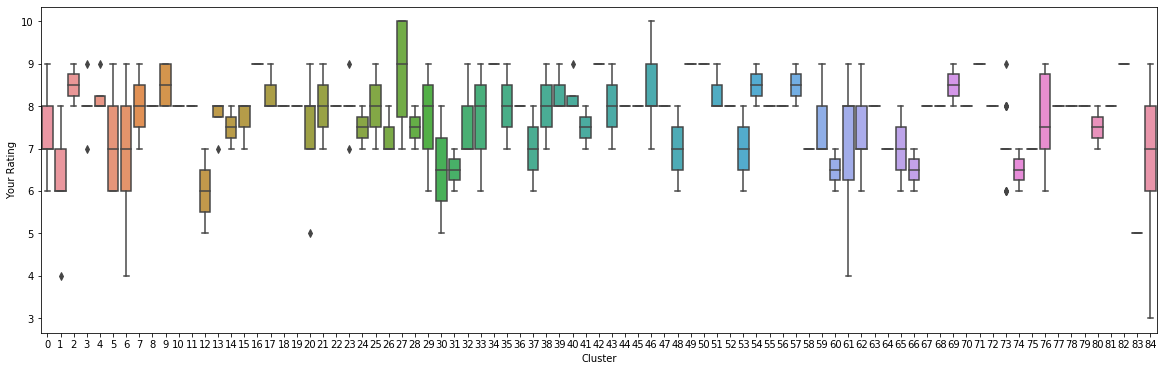

In [395]:
plt.figure(figsize=(20,6))
sns.boxplot(x = 'Cluster', y = 'Your Rating', data = data_film_orig)

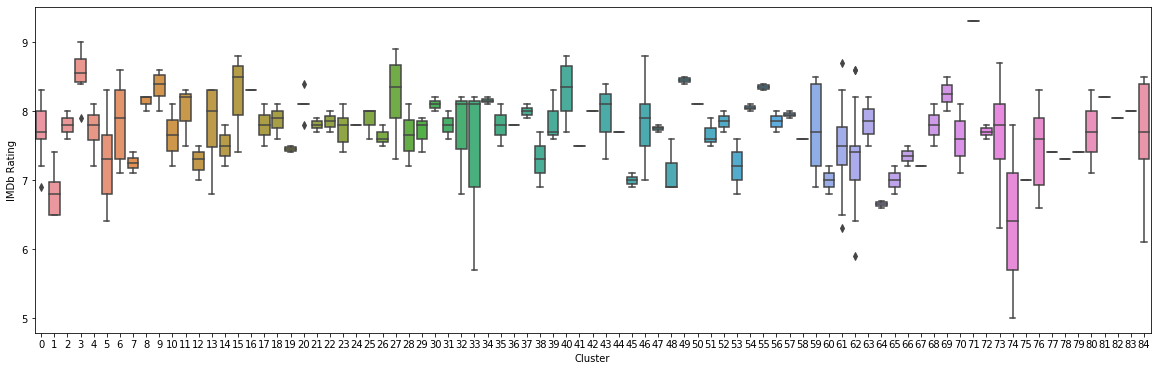

In [396]:
plt.figure(figsize=(20,6))
sns.boxplot(x = 'Cluster', y = 'IMDb Rating', data = data_film_orig)

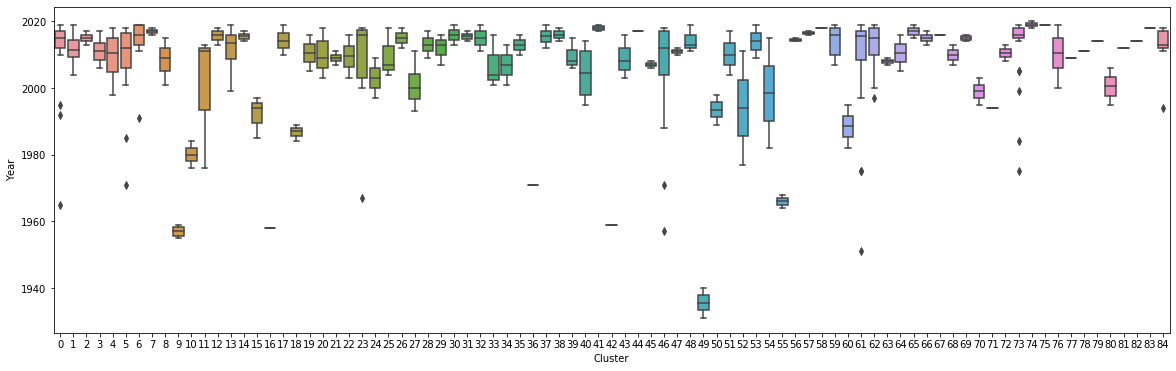

In [397]:
plt.figure(figsize=(20,6))
sns.boxplot(x = 'Cluster', y = 'Year', data = data_film_orig)

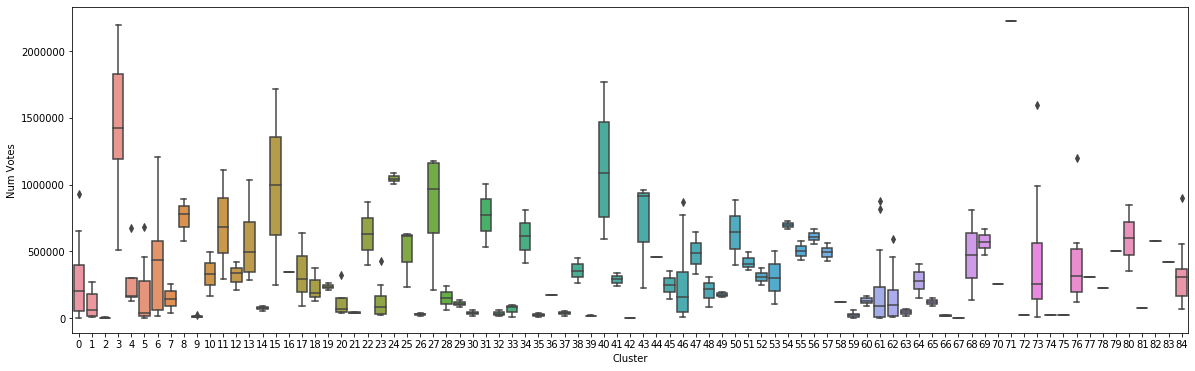

In [398]:
plt.figure(figsize=(20,6))
sns.boxplot(x = 'Cluster', y = 'Num Votes', data = data_film_orig)